In [2]:
%run setup.py

In [3]:
import lightkurve as lk

lc = lk.search_lightcurvefile('KIC 7668647', cadence='short', mission='Kepler', quarter=[14,15,16,17]).download_all().stitch().remove_nans()

/Users/danielhey/anaconda3/lib/python3.7/site-packages/lightkurve/collections.py:213: LightkurveWarning: Stitching a `LightCurveFileCollection` which contains both SAP and PDCSAP_FLUX. Using PDCSAP_FLUX. You can remove this warning by explicitely using `LightCurveFileCollection.PDCSAP_FLUX.stitch()`.
  LightkurveWarning)


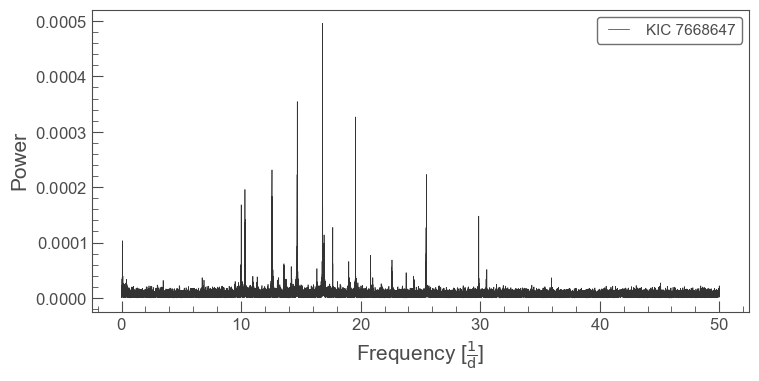

In [4]:
lc.to_periodogram(maximum_frequency=50).plot()

/Users/danielhey/anaconda3/lib/python3.7/site-packages/IPython/core/events.py:88: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/Users/danielhey/anaconda3/lib/python3.7/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


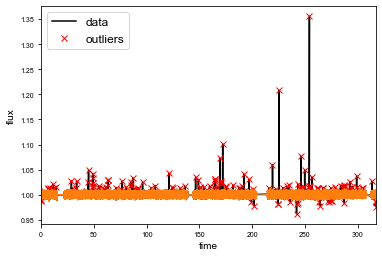

In [5]:
from scipy.signal import savgol_filter
import matplotlib.pyplot as plt

# Convert to parts per million
#df = pd.read_csv('sdb_wd_11558725.csv')
x = lc.time#df['time']
y = lc.flux#df['flux']
mu = np.median(y)
y = (y / mu )# * 1e3
#yerr = lc.flux_err * 1e6

# Identify outliers
m = np.ones(len(y), dtype=bool)
for i in range(10):
    y_prime = np.interp(x, x[m], y[m])
    smooth = savgol_filter(y_prime, 101, polyorder=3)
    resid = y - smooth
    sigma = np.sqrt(np.mean(resid**2))
    m0 = np.abs(resid) < 3*sigma
    if m.sum() == m0.sum():
        m = m0
        break
    m = m0

# Only discard positive outliers
m = (resid < 5*sigma) & (resid > -5*sigma)

# Shift the data so that the data start at t=0. This tends to make the fit
# better behaved since t0 covaries with period.
x_ref = np.min(x[m])
x -= x_ref

# Plot the data
plt.plot(x, y, "k", label="data")
plt.plot(x, smooth)
plt.plot(x[~m], y[~m], "xr", label="outliers")
plt.legend(fontsize=12)
plt.xlim(x.min(), x.max())
plt.xlabel("time")
plt.ylabel("flux")

# Make sure that the data type is consistent
x = np.ascontiguousarray(x[m], dtype=np.float64)
y = np.ascontiguousarray(y[m], dtype=np.float64)
smooth = np.ascontiguousarray(smooth[m], dtype=np.float64)

plt.plot(x,y)

In [6]:
xx = x#[::4]
yy = y#[::4]
len(x), len(xx)

(405972, 405972)

(0, 50)

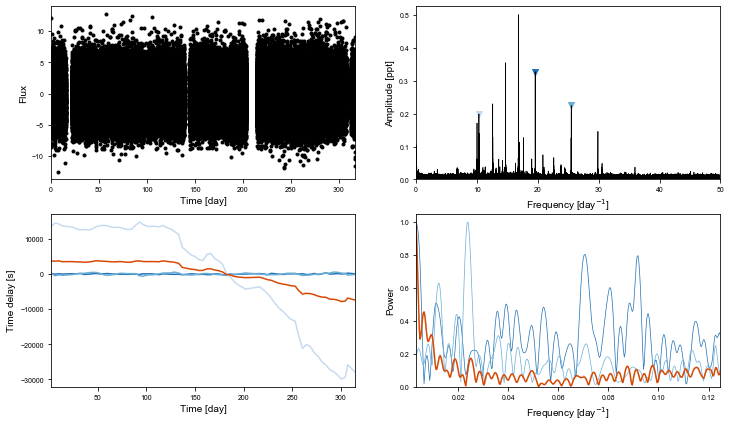

In [7]:
ms = Maelstrom(xx, yy, 
               freq = np.array([19.57289867, 25.49807722, 10.32404461]))

axes = ms.first_look(segment_size=4)
axes[1].set_xlim(0,50)

In [55]:
from tqdm import tqdm
import theano.tensor as tt

time, mag = ms.time, ms.flux
freq = ms.freq
with pm.Model() as simple_model:
    
    period = pm.Flat("period", testval=10.0)
    nu = pm.Flat("nu", testval=15)
    
    phi = xo.distributions.Angle("phi")
    logasini = pm.Uniform("logasini", lower=np.log(1), upper=np.log(1000),
                          testval=np.log(10))
    drift = pm.Normal("drift", mu=0, sd=1.0)
    
    M = 2.0 * np.pi * time / period - phi
    
    factor = 2. * np.pi * nu
    A = factor * (1 + drift) * time
    B = -factor * (tt.exp(logasini) / 86400) * tt.sin(M)
    
    sinarg = tt.sin(A+B)
    cosarg = tt.cos(A+B)
    
    DT = tt.stack((sinarg, cosarg, tt.ones_like(sinarg)))
    w = tt.slinalg.solve(tt.dot(DT, DT.T), tt.dot(DT, mag))
    pm.Deterministic("w", w)
    pm.Deterministic("phase", tt.arctan2(w[1], w[0]))
    lc_model = tt.dot(DT.T, w)
        
    pm.Normal("obs", mu=lc_model, observed=mag)
    
    fit_params = [v for v in simple_model.vars if v.name not in ["period", "nu"]]

def run_fit(p, nu):
    with simple_model:
        start = dict(simple_model.test_point)
        start["period"] = p
        start["nu"] = nu
        point, info = xo.optimize(start, vars=fit_params, return_info=True, verbose=False)
    return -info.fun, point

#periods = np.exp(np.linspace(np.log(10), np.log(25), 50))
periods = np.linspace(8, 20, 50)
results = []
for f in freq:
    results.append([run_fit(p, f) for p in tqdm(periods)])

100%|██████████| 50/50 [07:01<00:00,  7.79s/it]


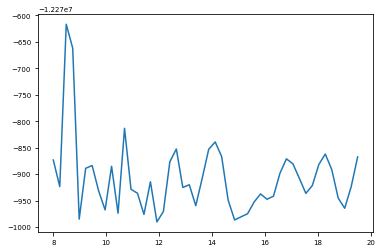

In [59]:
ys = np.array([[r[0] for r in row] for row in results])
sm = np.sum(ys, axis=0)
period_ind = np.argmax(sm)
plt.plot(periods[:-2], sm[:-2]);

In [47]:
ys = np.array([[r[0] for r in row] for row in results])
plt.plot(periods, ys[8]);

IndexError: index 8 is out of bounds for axis 0 with size 8

  6%|▌         | 6/100 [00:00<00:14,  6.71it/s]/Users/danielhey/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
100%|██████████| 100/100 [00:12<00:00,  8.12it/s]


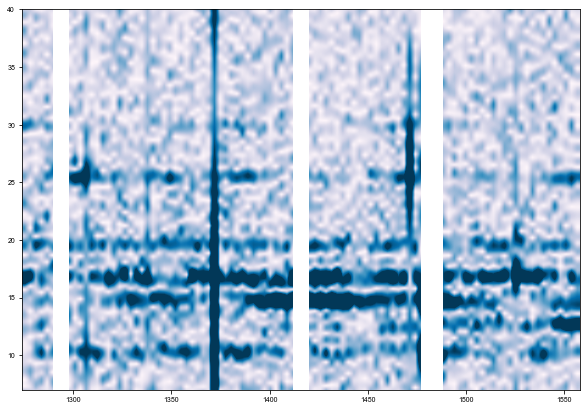

In [5]:
ax = kepdynamic(lc.time, lc.flux, fmin=7, fmax=40, deltat=1, nslice=100, cmap='PuBu')

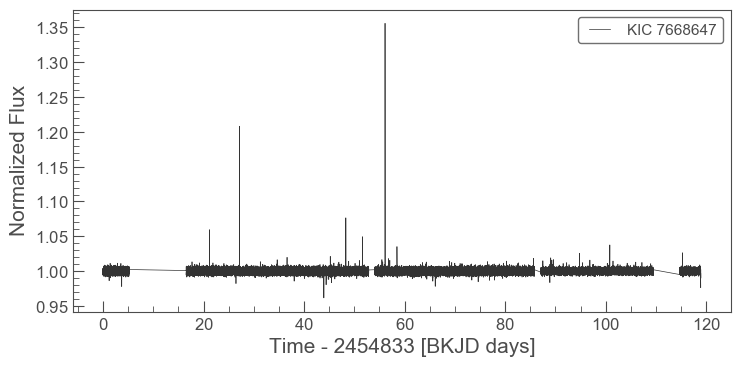

In [16]:
lc.plot()

In [4]:
import pandas as pd
import lightkurve as lk
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import skew

def kepdynamic(time, flux, fmin=0.1, fmax=10., nfreq=2000,ax=None,
               deltat=10., nslice=10, plot=False, plotscale='none', cmap='PuBu'):
    
    # read table columns
    barytime = time
    signal = flux

    # determine bounds of time slices
    t1, t2 = [], []
    dt = barytime[-1] - barytime[0]
    dt -= deltat
    if dt < 0:
        raise ValueError('ERROR -- KEPDYNAMIC: time slices are larger than data range')
    ds = dt / (nslice - 1)
    for i in range(nslice):
        t1.append(barytime[0] + ds * float(i))
        t2.append(barytime[0] + deltat + ds * float(i))

    # loop through time slices
    dynam = []
    for i in tqdm(range(nslice)):
        x, y = [], []
        for j in range(len(barytime)):
            if (barytime[j] >= t1[i] and barytime[j] <= t2[i]):
                x.append(barytime[j])
                y.append(signal[j])
        x = np.array(x, dtype='float64')
        y = np.array(y, dtype='float')
        y = y - np.median(y)

        # determine FT power
        fr = np.linspace(fmin, fmax, nfreq)
        try:
            power = LombScargle(x, y, y.max()-y.min()).power(fr)
            #model = LombScargle(x, y)
            #sc = model.power(freq, method="fast", normalization="psd")
        except:
            power = [np.nan]*nfreq

        for j in range(len(power)):
            dynam.append(power[j])

    # define shape of results array
    dynam = np.array(dynam, dtype='float64')
    dynam.shape = len(t1), len(power)
    
    #dynam = dynam[~np.isnan(dynam)]
    # image intensity min and max
    if plotscale == 'log':
        dynam = np.log10(dynam)
    elif plotscale == 'squareroot':
        dynam = np.sqrt(dynam)
    elif plotscale == 'loglog':
        dynam = np.log10(np.abs(np.log10(dynam)))
    nstat = 2; pixels = []
    for i in range(dynam.shape[0]):
        for j in range(dynam.shape[1]):
            pixels.append(dynam[i, j])
    pixels = np.array(np.sort(pixels), dtype='float')
    if int(float(len(pixels)) * 0.1 + 0.5) > nstat:
        nstat = int(float(len(pixels)) * 0.1 + 0.5)
    zmin = np.median(pixels[:nstat])
    zmax = np.median(pixels[-1:])
    if np.isnan(zmax):
        zmax = np.median(pixels[-nstat // 2:])
    if np.isnan(zmax):
        zmax = np.nanmax(pixels)

    # plot power spectrum
    if ax is None:
        fig, ax = plt.subplots(figsize=[10,7])
    #plt.axes([0.08,0.113,0.91,0.86])
    dynam = dynam.transpose()
    ax.imshow(np.sqrt(dynam), origin='lower', aspect='auto', cmap=cmap, vmin=zmin,
               vmax=zmax, extent=[barytime[0], barytime[-1], fmin, fmax],
               interpolation='bilinear')
    return ax

In [8]:
period_guess = 14.2
a_guess = 50.8

time, flux = ms.time, ms.flux
freq = ms.freq

In [9]:
from exoplanet.orbits import get_true_anomaly
import exoplanet as xo
import astropy.units as u
import theano.tensor as tt
import theano
from maelstrom.orbit import Orbit

with pm.Model() as new_model:
#     logP = pm.Bound(pm.Normal, lower=1, upper=25)("logP", mu=np.log(period_guess), sd=5, shape=1, testval=np.log(period_guess))
#     period = pm.Deterministic("period", pm.math.exp(logP))
    period = pm.Bound(pm.Normal, lower=1, upper=30)("P", mu=period_guess, sd=5,
                                     shape=1, testval=period_guess)
    asini = pm.Normal('asini', mu=a_guess, sd=10, testval=a_guess)
    phi = xo.distributions.Angle('phi', testval=0)
    mean = pm.Normal("mean", mu=np.mean(ms.flux), sd=10.0, testval=np.mean(ms.flux))
    logs_lc = pm.Normal('logs_lc', mu=np.log(np.median(np.abs(np.diff(ms.flux)))), sd=1, testval=np.log(np.median(np.abs(np.diff(ms.flux)))))
    
    omega = xo.distributions.Angle('omega', testval=0)
    eccen = pm.Uniform("ecc", lower=0.0, upper=0.9, testval=0.001)
    lognu = pm.Normal("lognu", mu=np.log(freq), sd=0.1, shape=len(freq))
    nu = pm.Deterministic("nu", tt.exp(lognu))
    
    orbit = Orbit(period=period,
                 lighttime=asini,
                 eccen=eccen,
                 omega=omega,
                 phi=phi,
                 freq=nu)
    
    full_lc = orbit.get_lightcurve_model(time, flux)
    
    pm.Normal('obs', mu=full_lc - mean, 
                  sd=tt.exp(2*logs_lc), 
                  observed=flux)

In [75]:
with new_model:
    map_params = xo.optimize(start=None, vars=[mean,logs_lc])
#     map_params = xo.optimize(start=map_params, vars=[eccen, omega])
    map_params = xo.optimize(start=map_params, vars=[phi])
    map_params = xo.optimize(start=map_params, vars=[lognu])
    map_params = xo.optimize(start=map_params)
    
    map_params = xo.optimize(start=map_params, vars=[asini])
    map_params = xo.optimize(start=map_params)

    map_params = xo.optimize(start=map_params, vars=[period])

optimizing logp for variables: [logs_lc, mean]
71it [00:13,  5.17it/s, logp=-9.280341e+05]
message: Optimization terminated successfully.
logp: -1043106.9922662213 -> -928034.0881308242
optimizing logp for variables: [phi]
86it [00:21,  3.97it/s, logp=-9.279755e+05]
message: Optimization terminated successfully.
logp: -928034.0881308242 -> -927975.4557815074
optimizing logp for variables: [lognu]
89it [00:20,  4.32it/s, logp=-9.279753e+05]
message: Desired error not necessarily achieved due to precision loss.
logp: -927975.4557815074 -> -927975.3358834323
optimizing logp for variables: [lognu, ecc, omega, logs_lc, mean, phi, asini, P]
101it [00:27,  3.63it/s, logp=-9.279475e+05]
message: Desired error not necessarily achieved due to precision loss.
logp: -927975.3358834323 -> -927947.5122495831
optimizing logp for variables: [asini]
3it [00:00,  4.51it/s, logp=-9.279475e+05]
message: Optimization terminated successfully.
logp: -927947.5122495831 -> -927947.5122495831
optimizing logp fo

In [76]:
map_params

{'P_interval__': array([-0.19141921]),
 'asini': array(55.69211503),
 'phi_angle__': array([4.44951694, 0.44949091]),
 'mean': array(-0.00013769),
 'logs_lc': array(0.43344471),
 'omega_angle__': array([-4.47092133, -0.10246218]),
 'ecc_interval__': array(0.38070636),
 'lognu': array([2.97414626, 3.23860343, 2.3344773 ]),
 'P': array([14.1164328]),
 'phi': array(1.47011772),
 'omega': array(-1.59370978),
 'ecc': array(0.53463911),
 'nu': array([19.57290598, 25.49808706, 10.32406216])}

In [77]:
np.random.seed(42)
with new_model:
    trace = pm.sample(
        tune=1000, 
        draws=1000, 
        step=xo.get_dense_nuts_step(target_accept=0.9), 
        start=map_params
    )
    
pm.save_trace(trace,'trace/7668647_REFEREE')

Multiprocess sampling (4 chains in 4 jobs)
NUTS: [lognu, ecc, omega, logs_lc, mean, phi, asini, P]
Sampling 4 chains: 100%|██████████| 8000/8000 [14:56:13<00:00,  8.31s/draws]  


'trace/7668647_REFEREE'

In [10]:
with new_model:
    trace = pm.load_trace('trace/7668647_REFEREE')

In [11]:
trace.varnames

['P_interval__',
 'asini',
 'phi_angle__',
 'mean',
 'logs_lc',
 'omega_angle__',
 'ecc_interval__',
 'lognu',
 'P',
 'phi',
 'omega',
 'ecc',
 'nu']

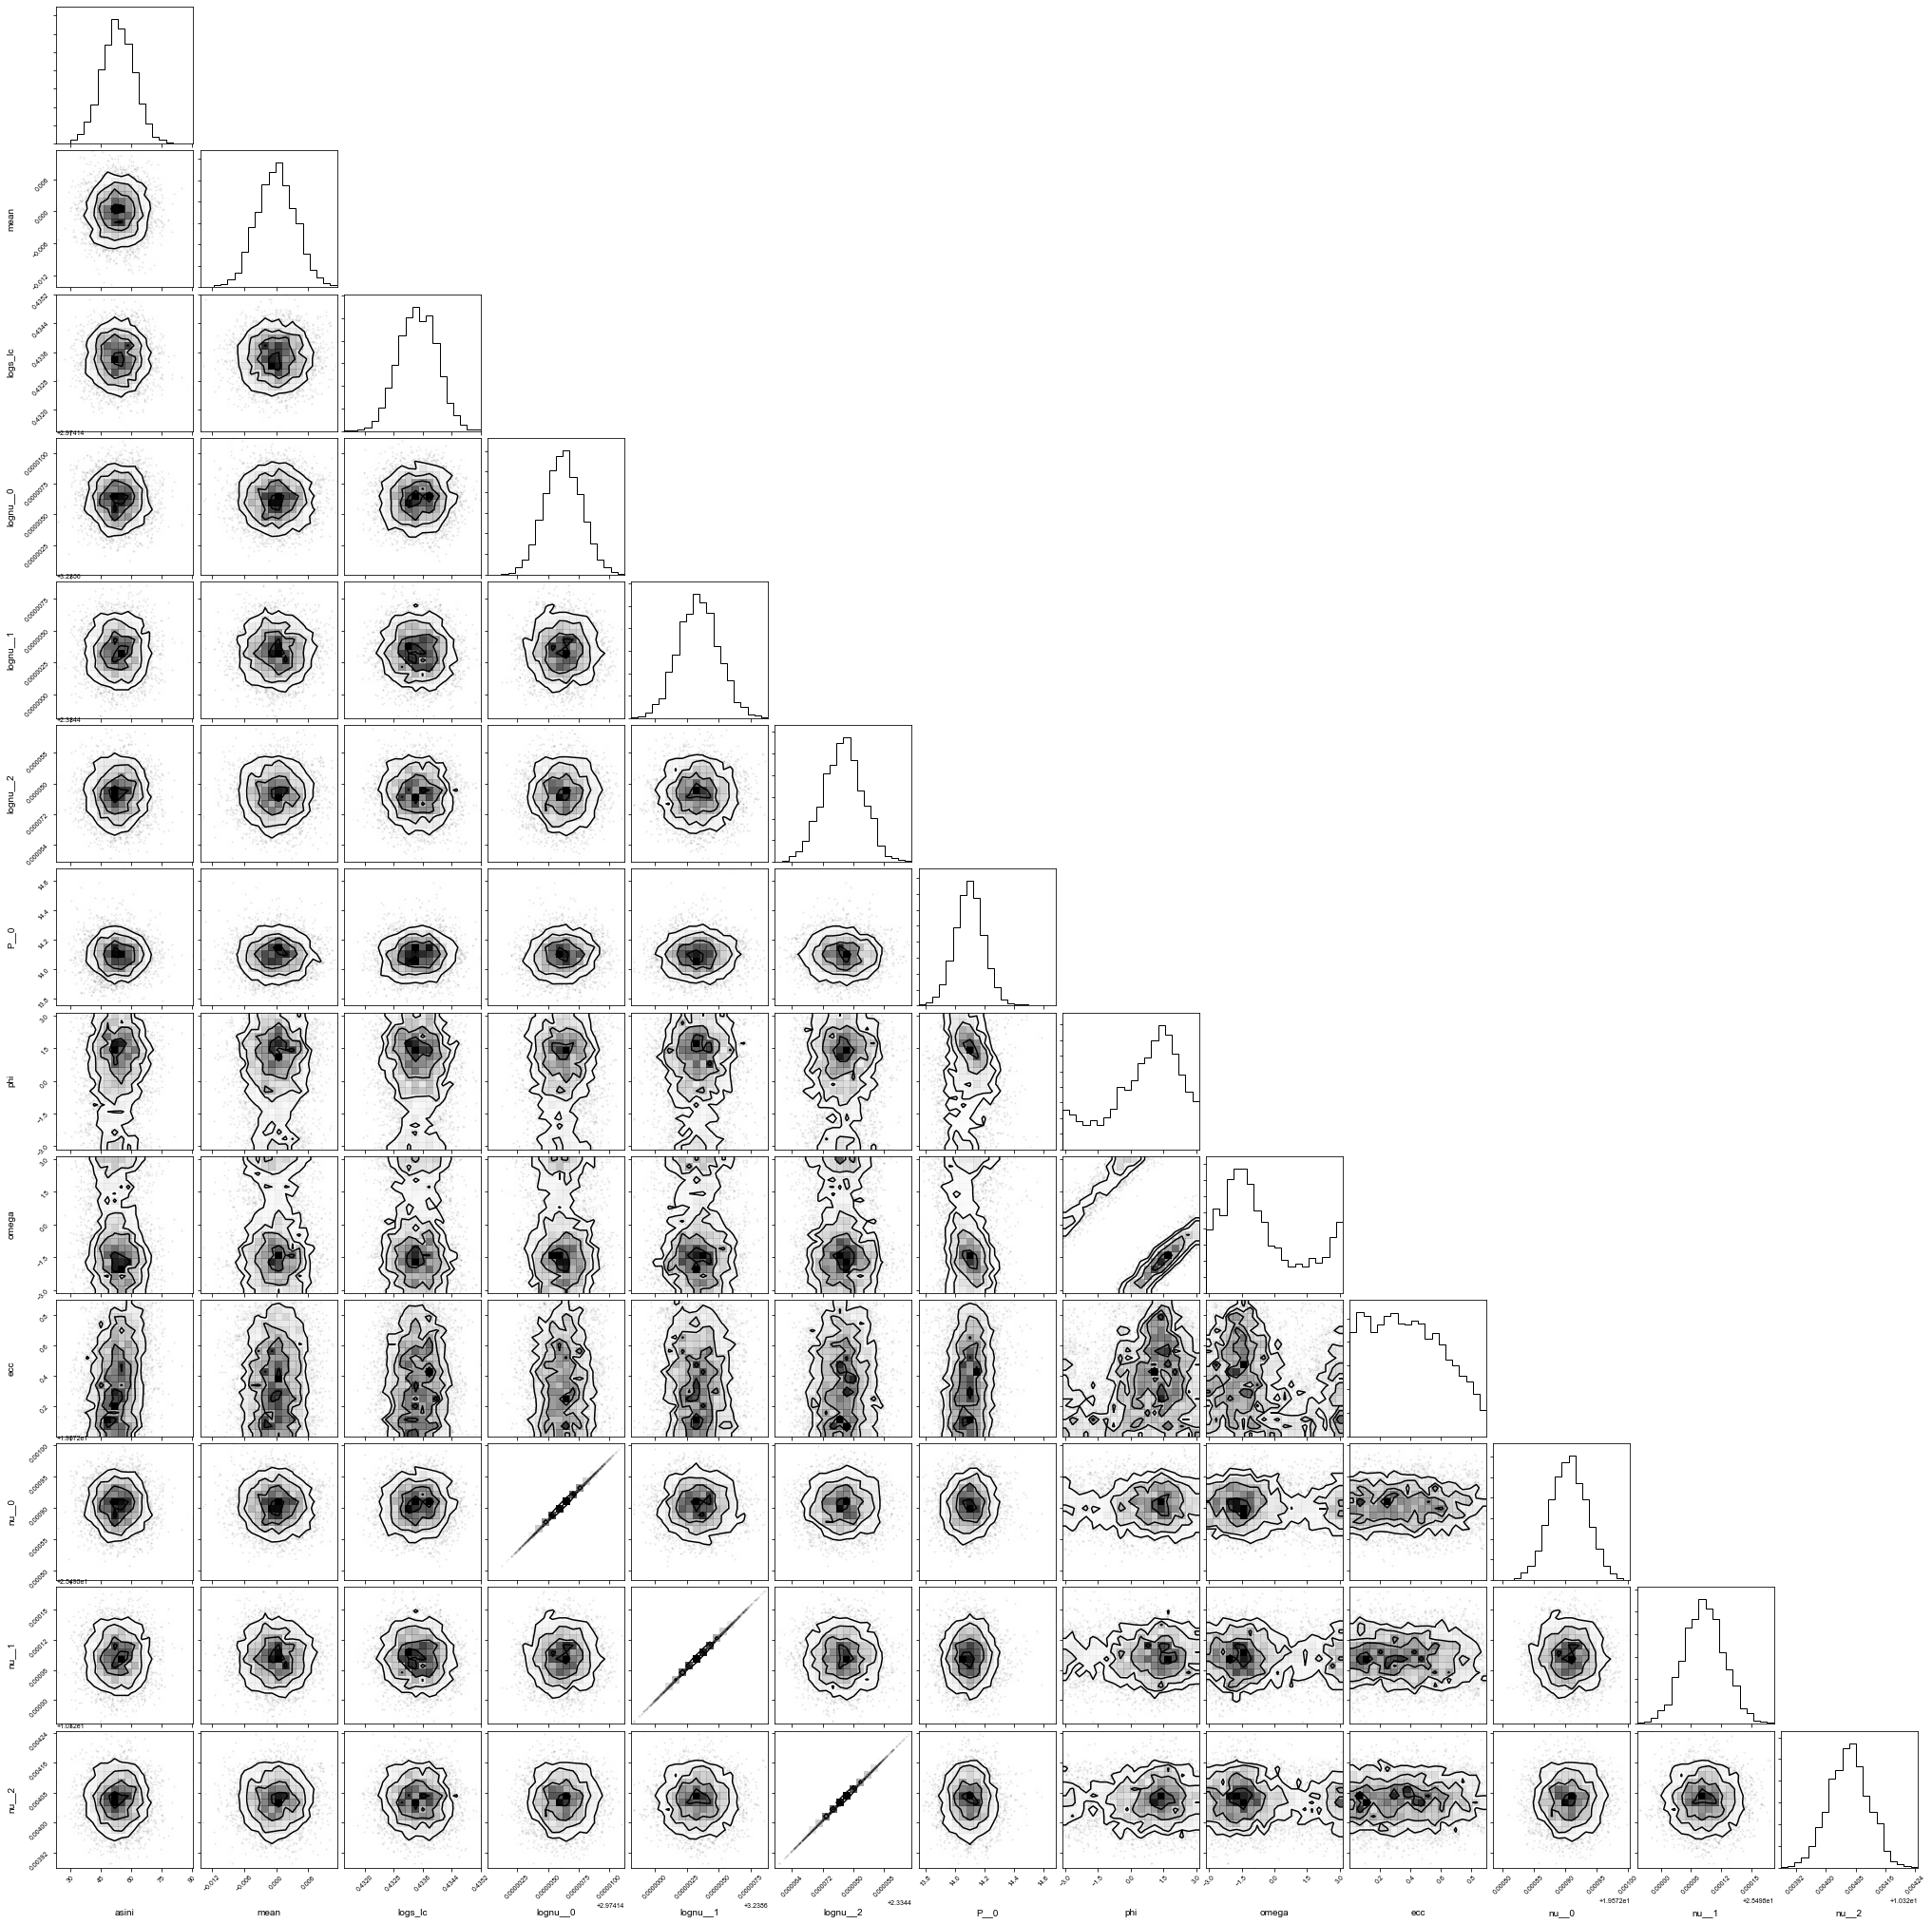

In [15]:
import corner

corner.corner(pm.trace_to_dataframe(trace));

In [17]:

varnames = ["P", "asini", "ecc", "omega", "phi"]
for var in varnames:
    percentiles = np.percentile(trace[var], q=[15.87, 50, 84.13])
    print(f'{var}: {percentiles[1]:.1f} + {percentiles[1] - percentiles[0]:.1f} - {percentiles[2] - percentiles[1]:.1f}')

P: 14.1 + 0.1 - 0.1
asini: 53.3 + 7.9 - 8.1
ecc: 0.4 + 0.3 - 0.3
omega: -1.1 + 1.2 - 2.9
phi: 0.9 + 2.0 - 1.2


In [18]:
from maelstrom.utils import mass_function
import astropy.units as u
rounding = 3
samples = pm.trace_to_dataframe(trace, varnames=['P', 'asini'])
mfs = mass_function(samples['P__0'].values * u.day, samples['asini'].values*u.s)
#mfs = np.array(mfs)
upper, med, lower = np.percentile(mfs.value, [84.13, 50, 15.86])
print('mass_func', ': ', np.round(med,rounding), ' + ', np.round(upper - med,rounding), ' - ', np.round(med - lower,rounding))

mass_func :  0.82  +  0.435  -  0.315


No handles with labels found to put in legend.


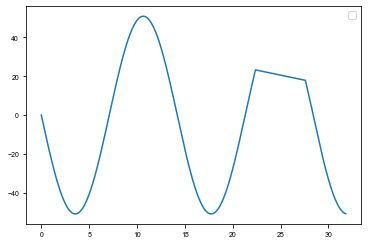

In [8]:
from exoplanet.orbits import get_true_anomaly
import exoplanet as xo
import astropy.units as u
import theano.tensor as tt
import theano

with_gp = False
with_eccen =True

with pm.Model() as new_model:
    # Period
#     logP = pm.Normal("logP", mu=np.log(period_guess), sd=1, shape=1, testval=np.log(period_guess))
    
    logP = pm.Bound(pm.Normal,
                         lower=np.log(11.5),
                         upper=np.log(20))("logP", mu=np.log(period_guess), sd=1, shape=1, testval=np.log(period_guess))
    period = pm.Deterministic("period", pm.math.exp(logP))
    asini = pm.Normal('asini', mu=a_guess, sd=10, testval=a_guess)
    phi = xo.distributions.Angle('phi', testval=0)
    mean = pm.Normal("mean", mu=np.mean(ms.flux), sd=10.0, testval=np.mean(ms.flux))
    logs_lc = pm.Normal('logs_lc', mu=np.log(np.median(np.abs(np.diff(ms.flux)))), sd=1, testval=np.log(np.median(np.abs(np.diff(ms.flux)))))
    sigma = pm.Deterministic('sigma', tt.exp(2*logs_lc))
    #     logs_lc = pm.HalfNormal("logs_lc",  sigma=0.25, testval=0.05)
    M = 2.0 * np.pi * (ms.time) / period - phi
    
    if with_eccen:
        varpi = xo.distributions.Angle('varpi', testval=0)
        eccen = pm.Uniform("ecc", lower=0.0, upper=0.9, testval=0.001)
        f = get_true_anomaly(M, eccen + tt.zeros_like(M))
        psi = -(1 - tt.square(eccen)) * tt.sin(f+varpi) / (1 + eccen*tt.cos(f))
    else:
        psi = -tt.sin(M)
        
    lognu = pm.Normal("lognu", mu=np.log(freq), sd=0.1, shape=len(freq))
    nu = pm.Deterministic("nu", tt.exp(lognu))
    tau = ((asini) / 86400) * psi[:, None]
    arg = 2. * np.pi * nu * (ms.time[:, None] - tau)
    D = tt.concatenate((tt.cos(arg), tt.sin(arg)), axis=-1)
    w = tt.slinalg.solve(tt.dot(D.T, D), tt.dot(D.T, ms.flux))
    pm.Deterministic('w', w)
    lc_model = tt.dot(D, w)
    full_lc = lc_model - mean
    
    if with_gp:
        logw0 = pm.Bound(pm.Normal,
                         lower=np.log(2*np.pi/100.0),
                         upper=np.log(2*np.pi/2))("logw0", mu=np.log(2*np.pi/10), sd=10,
                                                    testval=np.log(2*np.pi/10))
        logpower = pm.Normal("logpower", mu=np.log(np.var(ms.flux)), sd=10)
        logS0 = pm.Deterministic("logS0", logpower - 4 * logw0)
        kernel = xo.gp.terms.SHOTerm(log_S0=logS0, log_w0=logw0, Q=1/np.sqrt(2))
        gp = xo.gp.GP(kernel, ms.time, tt.exp(2*logs_lc) + tt.zeros(len(ms.time)), J=2)

        pm.Potential("obs", gp.log_likelihood(ms.flux - full_lc))
    else:
        pm.Normal('obs', mu=full_lc, 
                  sd=sigma, 
                  observed=ms.flux)
with new_model:
#     plt.plot(ms.time, ms.tau * 86400, label='Data')
    plt.plot(ms.time, xo.eval_in_model(psi * asini))
    plt.legend()
#     plt.xlim(200,300)

In [27]:
with new_model:
    #map_params = xo.optimize(start=None, vars=[phi, varpi])
#     map_params = xo.optimize(start=None, vars=[logP, asini])
    map_params = xo.optimize(start=None, vars=[mean,logs_lc])
    if with_eccen:
        map_params = xo.optimize(start=map_params, vars=[eccen, varpi])
#     map_params = xo.optimize(start=map_params, vars=[ecosw, esinw])
    map_params = xo.optimize(start=map_params, vars=[phi])
    map_params = xo.optimize(start=map_params, vars=[lognu])
    map_params = xo.optimize(start=map_params)
    
    map_params = xo.optimize(start=map_params, vars=[asini])
    map_params = xo.optimize(start=map_params)

    map_params = xo.optimize(start=map_params, vars=[logP])
    if with_gp:
        map_params = xo.optimize(start=map_params, vars=[logpower, logw0])

optimizing logp for variables: [logs_lc, mean]
17it [00:00, 18.41it/s, logp=-8.393111e+04]
message: Optimization terminated successfully.
logp: -92893.65490070586 -> -83931.11479653954
optimizing logp for variables: [varpi, ecc]
21it [00:00, 34.90it/s, logp=-8.390180e+04]
message: Optimization terminated successfully.
logp: -83931.11479653954 -> -83901.80392084464
optimizing logp for variables: [phi]
11it [00:00, 27.26it/s, logp=-8.388128e+04]
message: Optimization terminated successfully.
logp: -83901.80392084464 -> -83881.27656854957
optimizing logp for variables: [lognu]
17it [00:00, 31.79it/s, logp=-8.388110e+04]
message: Optimization terminated successfully.
logp: -83881.27656854957 -> -83881.09569364492
optimizing logp for variables: [lognu, ecc, varpi, logs_lc, mean, phi, asini, logP]
196it [00:05, 37.11it/s, logp=-8.388074e+04]
message: Desired error not necessarily achieved due to precision loss.
logp: -83881.09569364492 -> -83880.74284073661
optimizing logp for variables: [as

In [28]:
map_params

{'logP_interval__': array([-0.49801004]),
 'asini': array(54.48114339),
 'phi_angle__': array([1.77880752, 4.10315002]),
 'mean': array(-0.00119793),
 'logs_lc': array(0.37397822),
 'varpi_angle__': array([-2.31283962,  3.82763511]),
 'ecc_interval__': array(0.47816286),
 'lognu': array([2.53261735, 2.8220997 , 2.97420969]),
 'logP': array([2.65153132]),
 'period': array([14.17572961]),
 'phi': array(0.40906701),
 'sigma': array(2.11267823),
 'varpi': array(-0.54353694),
 'ecc': array(0.55558257),
 'nu': array([12.58640614, 16.81211404, 19.5741474 ]),
 'w': array([-0.55920306,  0.29476991, -0.22289564, -0.69138785, -0.63283725,
         0.21270192])}

In [29]:
sampler = xo.PyMC3Sampler(window=200, finish=500)
with new_model:
    burnin = sampler.tune(tune=1000, step_kwargs=dict(target_accept=0.9), start=map_params)

Sampling 2 chains: 100%|██████████| 1004/1004 [08:36<00:00,  1.94draws/s]


In [30]:
with new_model:
    trace = sampler.sample(draws=1000)

Multiprocess sampling (2 chains in 2 jobs)
NUTS: [lognu, ecc, varpi, logs_lc, mean, phi, asini, logP]
Sampling 2 chains: 100%|██████████| 2000/2000 [12:20<00:00,  2.70draws/s]
The number of effective samples is smaller than 25% for some parameters.


In [19]:
pm.summary(trace)

/Users/danielhey/anaconda3/lib/python3.7/site-packages/pymc3/stats.py:991: FutureWarning: The join_axes-keyword is deprecated. Use .reindex or .reindex_like on the result to achieve the same functionality.
  axis=1, join_axes=[dforg.index])


,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
asini,46.890654,9.290560,2.017933e-01,29.270936,64.323599,1692.457382,0.999519
mean,-0.001526,0.010817,2.229813e-04,-0.021408,0.020595,2293.146778,1.001032
logs_lc,0.373899,0.001860,3.687596e-05,0.370386,0.377469,2395.687045,0.999538
lognu__0,2.532616,0.000025,5.320607e-07,2.532570,2.532667,2323.660020,0.999523
lognu__1,2.822103,0.000026,5.198485e-07,2.822049,2.822149,2265.698321,0.999551
lognu__2,2.974204,0.000042,9.395748e-07,2.974122,2.974287,2169.608252,0.999602
logP__0,2.233182,0.045083,1.201001e-03,2.155190,2.318690,1475.501928,0.999858
period__0,9.339237,0.440549,1.220194e-02,8.550221,10.072594,1353.299552,1.000021
phi,-0.129236,2.043395,6.943939e-02,-3.085924,2.964952,776.719063,0.999687
sigma,2.112357,0.007859,1.559327e-04,2.097556,2.127478,2396.332599,0.999537


In [21]:
freqdf = pm.trace_to_dataframe(trace, varnames=['nu'])

In [43]:
perc = np.percentile(freqdf, axis=0, q=[16, 50, 84]).T
perc

array([[12.58606975, 12.58639035, 12.58668985],
       [16.81173568, 16.81216142, 16.8125994 ],
       [19.57321967, 19.57404685, 19.5748756 ]])

In [56]:
for per in perc:
    print(f'${per[1]:.4f}^{{+{(per[1] - per[0]):.4f}}}_{{-{(per[2] - per[1]):.4f}}}$')

$12.5864^{+0.0003}_{-0.0003}$
$16.8122^{+0.0004}_{-0.0004}$
$19.5740^{+0.0008}_{-0.0008}$


In [33]:
# pm.save_trace(trace, 'trace/7668647_ABSOLUTE_FINAL')

'traces/7668647_ABSOLUTE_FINAL'

In [15]:
with new_model:
    trace = pm.load_trace('trace/7668647')

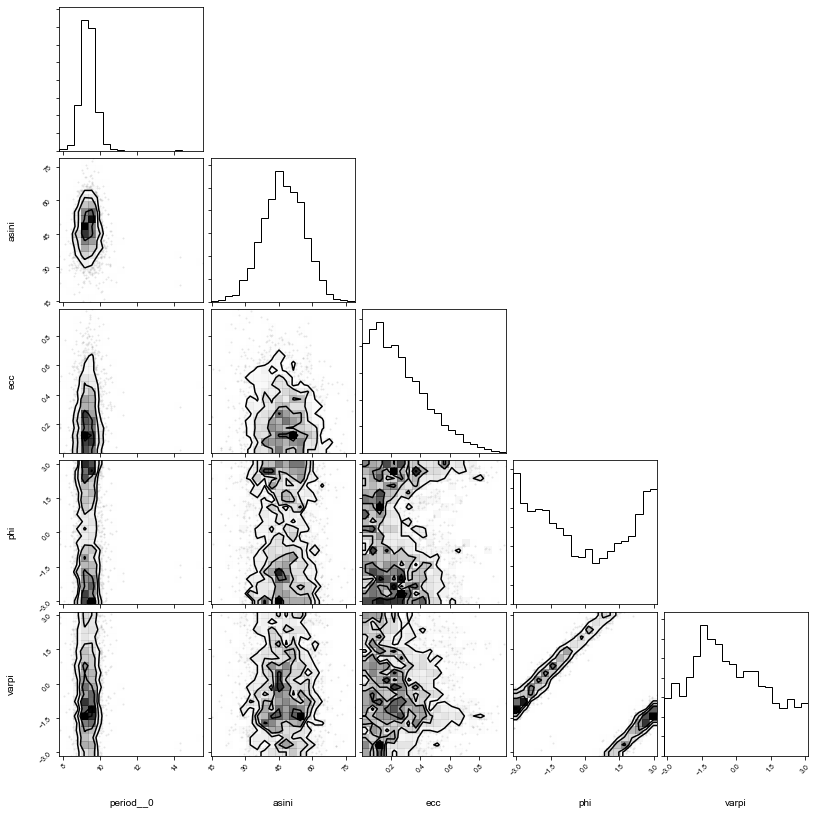

In [16]:
import corner

corner.corner(pm.trace_to_dataframe(trace, varnames=['period', 'asini', 'ecc', 'phi', 'varpi']));

In [17]:

varnames=['period', 'asini', 'phi', 'ecc', 'varpi']
rounding = 4
for varname in varnames:
    upper, med, lower = np.percentile(trace[varname], [84.13, 50, 15.86])
    print(varname, ': ', np.round(med,rounding), ' + ', np.round(upper - med,rounding), ' - ', np.round(med - lower,rounding))

period :  9.3269  +  0.3614  -  0.3583
asini :  46.9016  +  9.2057  -  9.3876
phi :  -0.4628  +  2.9368  -  2.0035
ecc :  0.2253  +  0.2349  -  0.1515
varpi :  -0.5059  +  2.1649  -  1.447


In [18]:
from maelstrom.utils import mass_function
import astropy.units as u
rounding = 3
samples = pm.trace_to_dataframe(trace, varnames=['period', 'asini'])
mfs = mass_function(samples['period__0'].values * u.day, samples['asini'].values*u.s)
#mfs = np.array(mfs)
upper, med, lower = np.percentile(mfs.value, [84.13, 50, 15.86])
print('mass_func', ': ', np.round(med,rounding), ' + ', np.round(upper - med,rounding), ' - ', np.round(med - lower,rounding))

mass_func :  1.295  +  0.91  -  0.65


In [66]:
samples

,period__0,asini
0,9.202383,41.167538
1,9.342918,41.913377
2,9.168847,51.849477
3,9.574080,61.753780
4,9.578831,32.100304
...,...,...
1995,8.707824,50.702067
1996,8.770516,43.902311
1997,9.323842,56.676692
1998,9.498864,42.538489
